# Helper functions

In [2]:
import re

import pandas as pd


def data_preparation(df: pd.DataFrame, keep_ratio: float = 0.8) -> pd.DataFrame:
    stats = (
        df.groupby(["Module", "Function"])
        .agg(
            mean_cpu=pd.NamedAgg(column="CPU Time", aggfunc="mean"),
            std_cpu=pd.NamedAgg(column="CPU Time", aggfunc="std"),
            mean_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="mean"),
            std_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="std"),
            mean_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="mean"),
            std_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="std"),
            mean_l1_bound=pd.NamedAgg(column="Memory Bound:L1 Bound(%)", aggfunc="mean"),
            mean_l2_bound=pd.NamedAgg(column="Memory Bound:L2 Bound(%)", aggfunc="mean"),
            mean_l3_bound=pd.NamedAgg(column="Memory Bound:L3 Bound(%)", aggfunc="mean"),
            mean_dram_bound=pd.NamedAgg(column="Memory Bound:DRAM Bound(%)", aggfunc="mean"),
            mean_store_bound=pd.NamedAgg(column="Memory Bound:Store Bound(%)", aggfunc="mean"),
        )
        .sort_values(by="mean_cpu", ascending=False)
    )
    stats["perc_cpu_time"] = stats["mean_cpu"] / stats["mean_cpu"].sum() * 100
    stats["cumperc_cpu_time"] = stats["perc_cpu_time"].cumsum()
    hotspots = stats[
        stats["cumperc_cpu_time"] <= max(keep_ratio * 100, stats["cumperc_cpu_time"].iloc[0])
    ]

    # Total CPU Time per module
    module_mean_cpu = hotspots.groupby("Module")["mean_cpu"].sum().to_dict()
    hotspots = hotspots.reset_index()
    hotspots["module_cpu"] = hotspots["Module"].map(module_mean_cpu)

    # Clean Function and Module names
    def module_short(module: str) -> str:
        if m := re.match(r"^\w+\.so", module):
            return m.group(0)
        return module

    hotspots["func_short"] = hotspots["Function"].apply(
        lambda x: re.sub(r"<.*>", "", x)
    )
    hotspots["module_short"] = hotspots["Module"].apply(module_short)

    # CPU Time sorted by "Module CPU Time" -> "CPU Time".
    hotspots = hotspots.sort_values(by=["module_cpu", "mean_cpu"], ascending=False)
    # Reorder the cumulative makespan for plotting.
    hotspots["cumperc_cpu_time"] = hotspots["perc_cpu_time"].cumsum()
    hotspots = hotspots.reset_index()
    hotspots.index += 1

    return hotspots

In [103]:
import math

from bokeh.models import (
    ColorBar,
    ColumnDataSource,
    FactorRange,
    HoverTool,
    LabelSet,
    LinearAxis,
    LinearColorMapper,
    Range1d,
    Whisker,
)
from bokeh.plotting import figure, show
from bokeh.transform import transform


def plot_hotspots(
    data: pd.DataFrame,
    *,
    y_limit: float | None = None,
    nthreads: int | None = None,
    colorbar_color: str = "Plasma256",
    colorbar_on: str,
    colorbar_title: str,
    pipeline: str,
    highlight: list[str] | None = None,
):
    xs = [(module, str(i)) for i, module in enumerate(data["module_short"], start=1)]
    source = ColumnDataSource(
        data=dict(
            x=xs,
            module=data["Module"].values,
            func=data["Function"].values,
            module_short=data["module_short"].values,
            func_short=data["func_short"].values,
            func_id=data.index.values,
            perc_cpu_time=data["perc_cpu_time"].values,
            cumperc_cpu_time=data["cumperc_cpu_time"].values,
            mean_cpu=data["mean_cpu"].values,
            std_cpu=data["std_cpu"].values,
            std_lower_cpu=data["mean_cpu"].values - data["std_cpu"].values,
            std_upper_cpu=data["mean_cpu"].values + data["std_cpu"].values,
            mean_mem_bound=data["mean_mem_bound"].values,
            std_mem_bound=data["std_mem_bound"].values,
            mean_fp=data["mean_fp"].values,
            std_fp=data["std_fp"].values,
        )
    )

    p = figure(
        x_range=FactorRange(*xs),
        title=(
            f"Avg. CPU Time (seconds): {pipeline}"
            + (f" with {str(nthreads)} threads" if nthreads else "")
        ),
        width=1500,
        toolbar_location=None,
    )

    # Tools
    hover = HoverTool()
    hover.tooltips = [
        ("Module", "@module"),
        # ("Function", "@func"),
        ("Module (short)", "@module_short"),
        ("Function (short)", "@func_short"),
        ("Function ID", "@func_id"),
        ("Makespan contribution", "@perc_cpu_time{1.1}%"),
        ("Makespan contribution (cumulative)", "@cumperc_cpu_time{1.1}%"),
        ("CPU Time (mean ± std)", "@mean_cpu{1.11} ± @std_cpu{1.11}"),
        (
            "% of memory bound (mean ± std)",
            "@mean_mem_bound{1.11} ± @std_mem_bound{1.11}",
        ),
        ("% of FP ops (mean ± std)", "@mean_fp{1.11} ± @std_fp{1.11}"),
    ]
    p.tools.append(hover)

    # Mean
    color_mapper = LinearColorMapper(palette=colorbar_color, low=0, high=100)
    color_bar = ColorBar(
        color_mapper=color_mapper,
        label_standoff=14,
        location=(0, 0),
        title=colorbar_title,
        title_text_font_size="20pt",
    )
    p.add_layout(color_bar, "left")
    p.vbar(
        x="x",
        top="mean_cpu",
        width=0.9,
        source=source,
        color=transform(colorbar_on, color_mapper),
    )
    # Error
    error = Whisker(
        base="x",
        upper="std_upper_cpu",
        lower="std_lower_cpu",
        source=source,
        level="annotation",
        line_width=2,
    )
    error.upper_head.size = 20
    error.lower_head.size = 20
    p.add_layout(error)

    # Cumulative makespan
    p.extra_y_ranges = {"percentage": Range1d(start=0, end=100)}
    p.add_layout(
        LinearAxis(y_range_name="percentage", axis_label="Cumulative CPU TIME (%)"),
        "right",
    )
    p.scatter(
        x="x",
        y="cumperc_cpu_time",
        source=source,
        y_range_name="percentage",
        color="lightgreen",
        size=10,
    )

    # # Bar labels
    # bar_labels = LabelSet(
    #     x="x",
    #     y=0,
    #     text="func_short",
    #     x_offset=0,
    #     y_offset=0,
    #     angle=math.pi / 2,
    #     source=source,
    #     text_color="black",
    #     text_font_size="0.8em",
    #     background_fill_color="white",
    #     background_fill_alpha=0.5,
    # )
    # p.add_layout(bar_labels)

    # Style
    if not y_limit:
        y_limit = 1.05 * (data["mean_cpu"].values + data["std_cpu"].values).max()
    p.y_range.end = y_limit
    p.y_range.start = 0
    # p.y_range = Range1d(start=0, end=y_limit)
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = math.pi / 2
    p.xaxis.group_label_orientation = math.pi / 8
    p.xaxis.separator_line_alpha = 0
    p.xgrid.grid_line_color = None
    p.yaxis.formatter.use_scientific = False

    ## Font size
    p.title.text_font_size = "25pt"
    p.xaxis.group_text_font_size = "12pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.yaxis.major_label_text_font_size = "15pt"

    # Prevent overlap of x-axis labels
    if (l := len(data)) > 120:
        p.xaxis.major_label_text_font_size = "6pt"
    elif l > 80:
        p.xaxis.major_label_text_font_size = "8pt"
    else:
        p.xaxis.major_label_text_font_size = "12pt"

    return p

In [4]:
from pathlib import Path

from bokeh.palettes import Colorblind8
from bokeh.transform import factor_cmap


def plot_cpu_time(path: Path, *, nthreads: int = 1, dataset=None):
    # Data preparation
    data = pd.concat(
        (
            pd.read_csv(filename, delimiter="\t").assign(
                filename=filename.stem,
                pipeline="/".join(filename.relative_to(path).parts[:2]),
            )
            for filename in path.rglob(f"**/{dataset}/**/*.csv" if dataset else "*.csv")
        ),
        ignore_index=True,
    )

    group = (
        data.groupby(["pipeline", "filename"])["CPU Time"]
        .sum()
        .divide(nthreads)
        .groupby("pipeline")
        .agg(["mean", "std"])
    )

    source = ColumnDataSource(
        data=dict(
            pipeline=group.index.values,
            mean=group["mean"].values,
            std=group["std"].values,
            std_lower=group["mean"].values - group["std"].values,
            std_upper=group["mean"].values + group["std"].values,
        )
    )

    # Plotting
    cmap = factor_cmap(
        "pipeline", palette=Colorblind8, factors=sorted(data["pipeline"].unique())
    )
    p = figure(
        x_range=group.index.values,
        width=1500,
        toolbar_location=None,
        y_axis_label="Total CPU time (seconds)",
    )

    p.vbar(
        x="pipeline",
        top="mean",
        width=0.9,
        source=source,
        line_color=cmap,
        fill_color=cmap,
    )
    # Error
    error = Whisker(
        base="pipeline",
        upper="std_upper",
        lower="std_lower",
        source=source,
        level="annotation",
        line_width=2,
    )
    error.upper_head.size = 20
    error.lower_head.size = 20
    p.add_layout(error)

    # Tools
    hover = HoverTool()
    hover.tooltips = [
        ("Pipeline", "@pipeline"),
        ("Makespan (mean ± std)", "@mean{1.11} ± @std{1.11}"),
    ]
    p.tools.append(hover)

    # Appearance
    p.left[0].formatter.use_scientific = False
    p.y_range.end = 1.05 * (group["mean"].values + group["std"].values).max()
    p.y_range.start = 0
    p.xaxis.major_label_orientation = math.pi / 8
    p.xgrid.grid_line_color = None
    p.outline_line_color = None

    ## Font size
    p.xaxis.major_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.yaxis.major_label_text_font_size = "20pt"

    return p

In [5]:
from collections import defaultdict
from pathlib import Path

from bokeh.palettes import Colorblind8
from bokeh.transform import factor_cmap
import numpy as np


def parse_makespan(filename):
    df = pd.read_csv(filename, delimiter="\t", on_bad_lines="skip")
    return float(df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0])


def plot_makespan(path: Path, *, dataset=None, pipeline_filter=None):
    # Data preparation
    data = defaultdict(list)
    for filename in path.rglob(
        f"**/{dataset}/**/*.makespan" if dataset else "*.makespan"
    ):
        pipeline = "/".join(filename.relative_to(path).parts[:2])
        if pipeline_filter and pipeline not in pipeline_filter:
            continue
        data[pipeline].append(parse_makespan(filename))

    pipelines = sorted(data.keys())
    means = np.array([np.mean(data[pipeline]) for pipeline in pipelines])
    stds = np.array([np.std(data[pipeline]) for pipeline in pipelines])

    source = ColumnDataSource(
        data=dict(
            pipeline=pipelines,
            mean=means,
            std=stds,
            std_lower=means - stds,
            std_upper=means + stds,
        )
    )

    # Plotting
    cmap = factor_cmap("pipeline", palette=Colorblind8, factors=pipelines)
    p = figure(
        x_range=pipelines,
        width=1500,
        toolbar_location=None,
        y_axis_label="Makespan (seconds)",
    )

    p.vbar(
        x="pipeline",
        top="mean",
        width=0.9,
        source=source,
        line_color=cmap,
        fill_color=cmap,
    )
    # Error
    error = Whisker(
        base="pipeline",
        upper="std_upper",
        lower="std_lower",
        source=source,
        level="annotation",
        line_width=2,
    )
    error.upper_head.size = 20
    error.lower_head.size = 20
    p.add_layout(error)

    # Tools
    hover = HoverTool()
    hover.tooltips = [
        ("Pipeline", "@pipeline"),
        ("Makespan (mean ± std)", "@mean{1.11} ± @std{1.11}"),
    ]
    p.tools.append(hover)

    # Appearance
    p.left[0].formatter.use_scientific = False
    p.y_range.end = 1.05 * (means + stds).max()
    p.y_range.start = 0
    p.xaxis.major_label_orientation = math.pi / 8
    p.xgrid.grid_line_color = None
    p.outline_line_color = None

    ## Font size
    p.xaxis.major_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.yaxis.major_label_text_font_size = "20pt"

    return p

In [116]:
import socket
import warnings

from selenium import webdriver


class remote_driver:
    def __enter__(self):
        options = webdriver.ChromeOptions()
        options.add_argument("--headless")
        options.add_argument("--window-size=1920,1080")
        options.add_argument("--ignore-ssl-errors=yes")
        options.add_argument("--ignore-certificate-errors")

        remote = socket.gethostbyname(socket.gethostname()) + ":4444"
        try:
            self.driver = webdriver.Remote(remote, options=options)
            self.driver.maximize_window()
            return self.driver
        except:
            warnings.warn("Failed to initialize Selenium webdriver.")
            return None

    def __exit__(self, exc_type, exc_value, exc_tb):
        if hasattr(self, "driver"):
            self.driver.quit()

In [117]:
from typing import Optional


from bokeh.io import export_png
from bokeh.plotting import output_file, save


def show_and_export(
    p: figure,
    *,
    fout: Optional[Path] = None,
    driver: Optional[webdriver.Remote] = None,
    hide_title: bool = False,
):
    if fout:
        if hide_title:
            p.title = ""
        fout.parent.mkdir(parents=True, exist_ok=True)
        export_png(p, filename=fout.as_posix() + ".png", webdriver=driver)

        # Save HTML file
        output_file(filename=fout.as_posix() + ".html")
        save(p)

    else:
        return show(p)

In [118]:
def read_profiling_data(path: Path, *, delimiter: str = "\t") -> pd.DataFrame:
    return pd.concat(
        (
            pd.read_csv(filename, delimiter=delimiter)
            for filename in path.rglob("*.csv")
        ),
        ignore_index=True,
    )

# Results

In [119]:
from bokeh.io import output_notebook


output_notebook()

figures_dir = Path("paper", "figures")
figures_dir.mkdir(parents=True, exist_ok=True, mode=0o755)

tables_dir = Path("paper", "tables")
tables_dir.mkdir(parents=True, exist_ok=True, mode=0o755)

profiling_dir = Path(
    "/", "mnt", "lustre", "mathdugre", "mri-bottleneck", "vtune_output"
)
dataset = "ds004513"
VERBOSE = False

Loading BokehJS ...

## Single-threaded

In [9]:
with remote_driver() as driver:
    show_and_export(
        plot_makespan(profiling_dir / "1-threads", dataset=dataset),
        fout=figures_dir / "makespan-1thread",
        driver=driver,
    )

/tmp/ipykernel_3096357/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [10]:
with remote_driver() as driver:
    show_and_export(
        plot_cpu_time(profiling_dir / "1-threads", dataset=dataset),
        fout=figures_dir / "cpu-time-1thread",
        driver=driver,
    )

/tmp/ipykernel_3096357/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [11]:
dataset = "ds004513"
experiments: dict[str, tuple[tuple[str, float | None]]] = {
    "ants": (
        ("brainExtraction", 700),
        ("brainExtraction-fp", 700),
        ("registrationSyN", 2200),
        ("registrationSyN-fp", 2200),
    ),
    "fsl": (
        ("fast", None),
        ("mcflirt", None),
        ("flirt", None),
    ),
    "freesurfer": (("reconall", None),),
    # "fmriprep": (("full", None),),
}

with remote_driver() as driver:
    for toolkit, pipelines in experiments.items():
        for pipeline, y_limit in pipelines:
            profiling_data = read_profiling_data(
                profiling_dir / "1-threads" / toolkit / pipeline / dataset
            )
            data = data_preparation(profiling_data, keep_ratio=0.8)
            p = plot_hotspots(
                data,
                pipeline=f"{toolkit}.{pipeline}",
                y_limit=y_limit,
                nthreads=1,
                colorbar_on="mean_mem_bound",
                colorbar_title="% of memory bound",
                colorbar_color="Plasma256",
            )

            _filename = f"hotspots-1thread-{toolkit}-{pipeline}"
            show_and_export(
                p,
                fout=figures_dir / f"{_filename}",
                driver=driver,
            )

            out_data = data[["module_short", "func_short", "mean_cpu", "std_cpu"]]
            out_data.to_csv(tables_dir / f"{_filename}.csv")
            if VERBOSE:
                print(out_data.head(10).to_string())

/tmp/ipykernel_3096357/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


## Multi-threaded (32 threads)

In [12]:
with remote_driver() as driver:
    show_and_export(
        plot_makespan(profiling_dir / "32-threads", dataset=dataset),
        fout=figures_dir / "makespan-32threads",
        driver=driver,
    )

/tmp/ipykernel_3096357/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [13]:
with remote_driver() as driver:
    show_and_export(
        plot_cpu_time(profiling_dir / "32-threads", nthreads=32, dataset=dataset),
        fout=figures_dir / "cpu-time-32threads",
        driver=driver,
    )

/tmp/ipykernel_3096357/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [14]:
experiments: dict[str, tuple[tuple[str, float | None]]] = {
    "ants": (
        ("brainExtraction", 1100),
        ("brainExtraction-fp", 1100),
        ("registrationSyN", 3000),
        ("registrationSyN-fp", 3000),
    ),
    "fsl": (
        ("fast", None),
        ("mcflirt", None),
        ("flirt", None),
    ),
    "freesurfer": (("reconall", None),),
    # "fmriprep": (("full", None),),
}

with remote_driver() as driver:
    for toolkit, pipelines in experiments.items():
        for pipeline, y_limit in pipelines:
            profiling_data = read_profiling_data(
                profiling_dir / "32-threads" / toolkit / pipeline
            )
            data = data_preparation(profiling_data, keep_ratio=0.8)
            p = plot_hotspots(
                data,
                pipeline=f"{toolkit}.{pipeline}",
                y_limit=y_limit,
                nthreads=32,
                colorbar_on="mean_mem_bound",
                colorbar_title="% of memory bound",
                colorbar_color="Plasma256",
            )

            _filename = f"hotspots-32threads-{toolkit}-{pipeline}"
            show_and_export(
                p,
                fout=figures_dir / f"{_filename}",
                driver=driver,
            )
            out_data = data[["module_short", "func_short", "mean_cpu", "std_cpu"]]
            out_data.to_csv(tables_dir / f"{_filename}.csv")
            if VERBOSE:
                print(out_data.head(10).to_string())

/tmp/ipykernel_3096357/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


# FreeSurfer threading

In [126]:
nthreads = (1, 2, 4, 8, 16, 32)
freesurfer_threading = [
    list(
        profiling_dir.glob(
            f"{i}-threads/freesurfer/reconall/ds004513/sub-s036/*.makespan"
        )
    )[0]
    for i in nthreads
]

# Data preparation
pipelines = [
    "/".join(filename.relative_to(profiling_dir).parts[:2])
    for filename in freesurfer_threading
]
makespans = [parse_makespan(filename) for filename in freesurfer_threading]
speedups = [makespans[0] / makespan for makespan in makespans]
efficiencies = [speedup / nthread * 100 for nthread, speedup in zip(nthreads, speedups)]

source = ColumnDataSource(
    data=dict(
        nthread=nthreads,
        pipeline=pipelines,
        makespan=makespans,
        speedup=[np.nan] + speedups[1:],
        efficiency=[np.nan] + efficiencies[1:],
    )
)

# Plotting
p = figure(
    width=1200,
    toolbar_location=None,
    x_axis_label="# of threads",
    y_axis_label="Makespan (seconds)",
)

p.line(
    x="nthread",
    y="makespan",
    source=source,
    width=3,
)
p.scatter(
    x="nthread",
    y="makespan",
    source=source,
    size=15,
    legend_label="Makespan",
)

# Tools
hover = HoverTool()
hover.tooltips = [
    ("Pipeline", "@pipeline"),
    ("Makespan", "@makespan{1.11}"),
    ("Speedup", "@speedup{1.11}"),
    ("Parallel Efficiency", "@efficiency{1.11}"),
]
p.tools.append(hover)

# Cumulative makespan
p.extra_y_ranges = {"percentage": Range1d(start=0, end=100)}
p.add_layout(
    LinearAxis(y_range_name="percentage", axis_label="Parallel efficiency (%)"),
    "right",
)
p.line(
    x="nthread",
    y="efficiency",
    source=source,
    y_range_name="percentage",
    color="red",
    width=3,
)
p.scatter(
    x="nthread",
    y="efficiency",
    source=source,
    y_range_name="percentage",
    color="red",
    size=15,
    marker="square",
    legend_label="Parallel efficiency",
)

# Appearance
p.left[0].formatter.use_scientific = False
p.y_range.end = 1.05 * max(makespans)
p.y_range.start = 0
p.xgrid.grid_line_color = None
p.outline_line_color = None
p.xaxis.ticker = nthreads

## Font size
p.xaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.yaxis.major_label_text_font_size = "20pt"
p.legend.label_text_font_size = "20pt"

with remote_driver() as driver:
    show_and_export(
        p,
        fout=figures_dir / "makespan-freesurfer",
        driver=driver,
    )
print(nthreads)
print(speedups)
print(efficiencies)

/tmp/ipykernel_3420379/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


(1, 2, 4, 8, 16, 32)
[1.0, 1.3237079309534956, 1.3554696405257673, 1.4890580446935193, 1.5647610165847086, 1.5782481813782403]
[100.0, 66.18539654767478, 33.88674101314418, 18.61322555866899, 9.77975635365443, 4.932025566807001]


# Long-tail distribution (Global)

In [40]:
profiling_data = read_profiling_data(profiling_dir / "1-threads")
data = (
    profiling_data.groupby(["Module", "Function"])
    .agg(
        mean_cpu=pd.NamedAgg(column="CPU Time", aggfunc="mean"),
        std_cpu=pd.NamedAgg(column="CPU Time", aggfunc="std"),
        mean_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="mean"),
        std_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="std"),
        mean_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="mean"),
        std_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="std"),
    )
    .sort_values(by="mean_cpu", ascending=False)
).reset_index()
data.index += 1
data["perc_cpu_time"] = data["mean_cpu"] / data["mean_cpu"].sum() * 100
data["cumperc_cpu_time"] = data["perc_cpu_time"].cumsum()

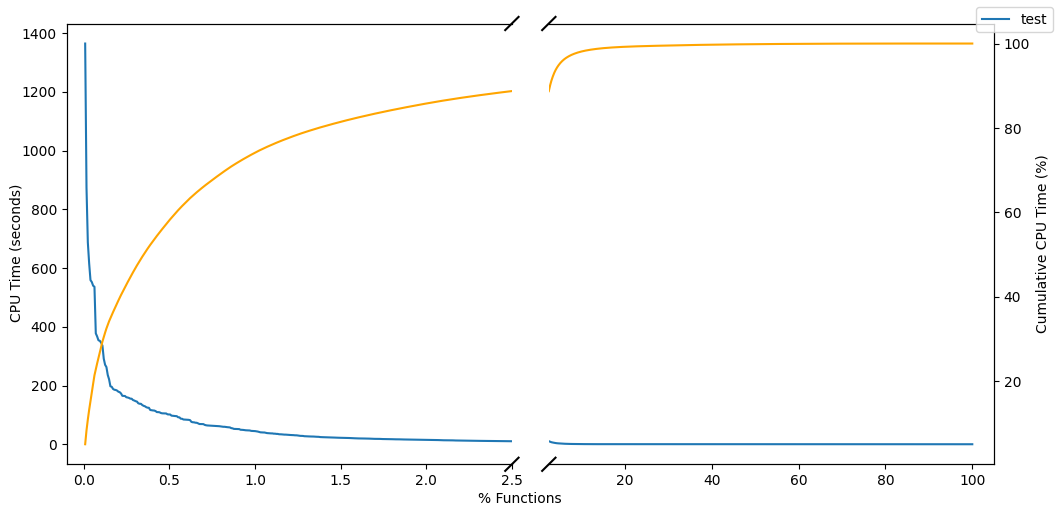

In [21]:
import matplotlib.pyplot as plt


fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor="w", figsize=(10, 5))
fig.tight_layout()

xlabels = data.index / len(data) * 100

ax.plot(xlabels, data["mean_cpu"], label="test")
ax2.plot(xlabels, data["mean_cpu"])
ax.set_xlim(-.1, 2.5)
ax2.set_xlim(2.5, None)

# hide the spines between ax and ax2
ax.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax.yaxis.tick_left()
ax2.yaxis.set_visible(False)

d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color="k", clip_on=False)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

fig.text(0.5, 0, "% Functions", ha="center")
fig.text(-0.01, 0.5, "CPU Time (seconds)", va="center", rotation="vertical")

# Secondary y-axis
ax11 = ax.twinx()
ax22 = ax2.twinx()
ax11.yaxis.set_visible(False)
ax11.spines["right"].set_visible(False)
ax22.spines["left"].set_visible(False)
ax22.set_ylabel("Cumulative CPU Time (%)")

ax11.plot(xlabels, data["cumperc_cpu_time"], c="orange")
ax22.plot(xlabels, data["cumperc_cpu_time"], c="orange")
fig.legend()

# fig.savefig(figures_dir / "global_longtail.png")
fig.show()

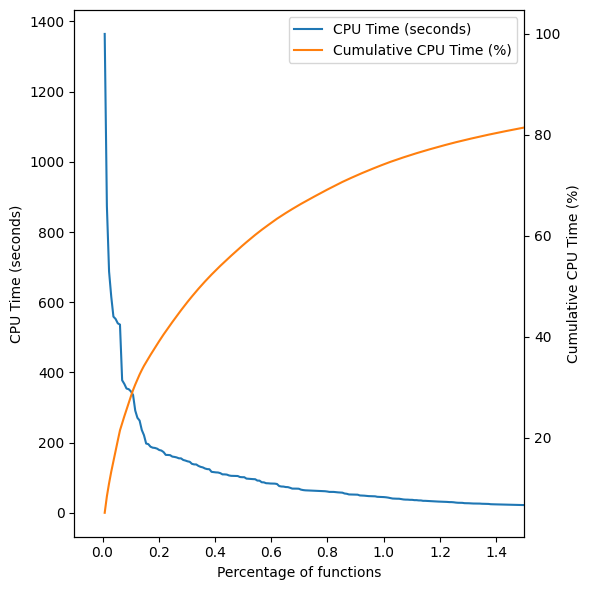

In [41]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(6, 6))
ax2 = ax.twinx()

xlabels = data.index / len(data) * 100
ax.plot(xlabels, data["mean_cpu"], label="CPU Time (seconds)")
ax2.plot(
    xlabels, data["cumperc_cpu_time"], c="tab:orange", label="Cumulative CPU Time (%)"
)
ax.set_xlim(-0.1, 1.5)

# Style
ax.set_ylabel("CPU Time (seconds)")
ax2.set_ylabel("Cumulative CPU Time (%)")
ax.set_xlabel("Percentage of functions")
fig.legend(loc="upper right", bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes)

# Show and Save the plot
plt.tight_layout()
plt.savefig(figures_dir / "global-longtail.png")
plt.show()

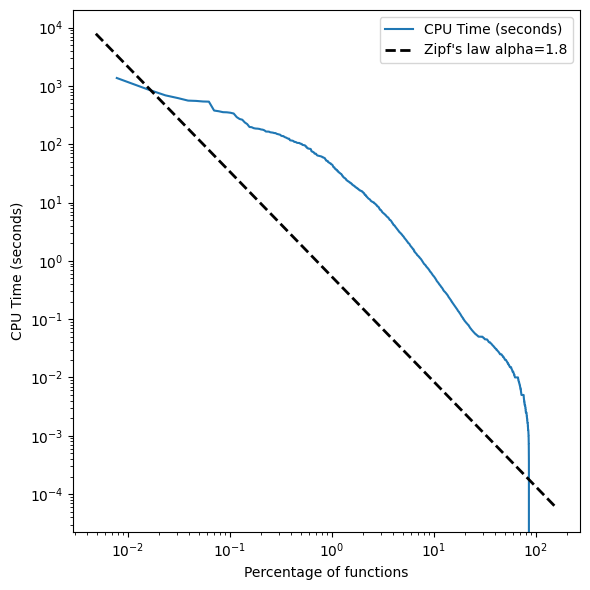

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import zeta


fig, ax = plt.subplots(figsize=(6, 6))
xlabels = data.index / len(data) * 100
ax.loglog(xlabels, data["mean_cpu"], label="CPU Time (seconds)")

x = np.linspace(*ax.get_xlim())
s = 1.8
ax.plot(
    x,
    x**-s / zeta(s),
    label=f"Zipf's law alpha={s}",
    linestyle="--",
    color="black",
    linewidth=2,
)

ax.set_ylabel("CPU Time (seconds)")
ax.set_xlabel("Percentage of functions")
fig.legend(loc="upper right", bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes)

plt.tight_layout()
plt.savefig(figures_dir / "global-zipf_law.png")
plt.show()

## QQ Plot

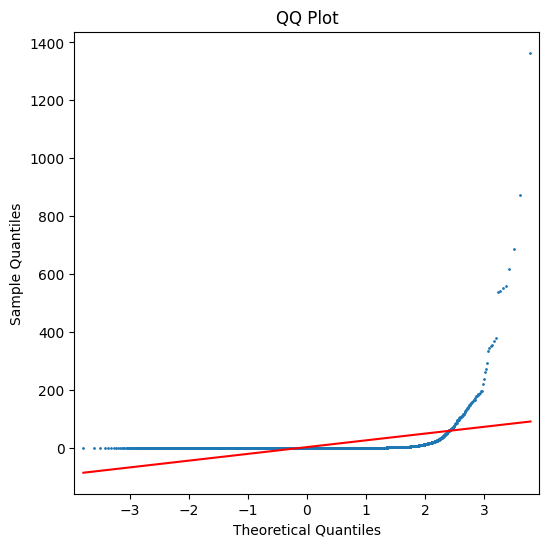

In [75]:
import statsmodels.api as sm

# Generate QQ plot
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(data["mean_cpu"], line="s", ax=ax, markersize=1)

# Set plot title and labels
ax.set_title("QQ Plot")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")

# Show and Save the plot
fig.savefig(figures_dir / "qq_plot.png")
plt.show()

In [19]:
import numpy as np
from scipy import stats
from bokeh.plotting import figure, show, output_notebook

n_quantiles = len(data)
# n_quantiles = 100
# Calculate quantiles
data_quantiles = np.quantile(data["mean_cpu"], np.linspace(0, 1, n_quantiles))
theoretical_quantiles = stats.norm.ppf(
    np.linspace(0, 1, n_quantiles)
)  # For a normal distribution

# Create a Bokeh plot
output_notebook()  # For inline display in a Jupyter Notebook
p = figure(
    title="QQ Plot", x_axis_label="Theoretical Quantiles", y_axis_label="Data Quantiles"
)

# Scatter plot for the QQ plot
p.circle(theoretical_quantiles, data_quantiles, size=5)

# Reference line (y=x)
theoretical_quantiles = theoretical_quantiles[~np.isinf(theoretical_quantiles)]
min_quantile = min(theoretical_quantiles)
max_quantile = max(theoretical_quantiles)
p.line([min_quantile, max_quantile], [min_quantile, max_quantile], color="red")

show(p)

Loading BokehJS ...

In [ ]:
# from scipy.stats import goodness_of_fit, genpareto


# res = goodness_of_fit(genpareto, data["mean_cpu"], statistic="ks")
# res

In [ ]:
# from scipy.stats import goodness_of_fit, lomax

# res = goodness_of_fit(lomax, data["mean_cpu"], statistic="ks")
# res

# ANTS Makespan: Single vs. Double Precision

In [22]:
# pipeline_filter = [
#     "ants/brainExtraction",
#     "ants/brainExtraction-fp",
#     "ants/registrationSyN",
#     "ants/registrationSyN-fp",
# ]

# with remote_driver() as driver:
#     show_and_export(
#         plot_makespan(
#             profiling_dir / "1-threads",
#             dataset=dataset,
#             pipeline_filter=pipeline_filter,
#         ),
#         fout=figures_dir / "makespan-ants",
#         driver=driver,
#     )

/tmp/ipykernel_3096357/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


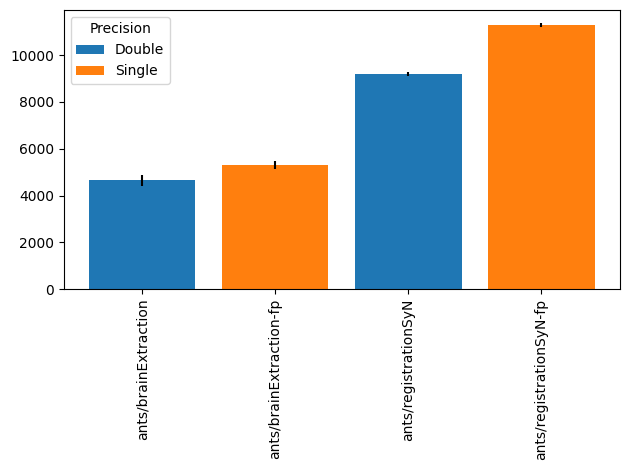

In [100]:
import matplotlib.pyplot as plt
from scipy import stats

path = profiling_dir / "1-threads"
pipeline_filter = [
    "ants/brainExtraction",
    "ants/brainExtraction-fp",
    "ants/registrationSyN",
    "ants/registrationSyN-fp",
]

data = defaultdict(list)
for filename in path.rglob(f"**/{dataset}/**/*.makespan" if dataset else "*.makespan"):
    pipeline = "/".join(filename.relative_to(path).parts[:2])
    if pipeline_filter and pipeline not in pipeline_filter:
        continue
    data[pipeline].append(parse_makespan(filename))

pipelines = sorted(data.keys())
means = np.array([np.mean(data[pipeline]) for pipeline in pipelines])
stds = np.array([np.std(data[pipeline]) for pipeline in pipelines])

plt.bar(
    pipelines,
    means,
    yerr=stds,
    label=["Double", "Single", "_Double", "_Single"],
    color=["tab:blue", "tab:orange", "tab:blue", "tab:orange"],
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(title="Precision")

plt.savefig(figures_dir / "makespan-ants.png")
plt.show()

In [95]:
print("p-value for ttest single vs. double (brainExtraction):")
stats.ttest_ind(data[pipeline_filter[0]], data[pipeline_filter[1]]).pvalue

p-value for ttest single vs. double (brainExtraction):


2.270069975581398e-11

In [96]:
print("p-value for ttest single vs. double (registrationSyN):")
stats.ttest_ind(data[pipeline_filter[2]], data[pipeline_filter[3]]).pvalue

p-value for ttest single vs. double (registrationSyN):


2.5872343066780315e-43

# Interpolation analysis

In [24]:
dataset = "ds004513"
experiments: dict[str, tuple[tuple[str, float | None]]] = {
    "ants": (
        ("brainExtraction", 700),
        ("brainExtraction-fp", 700),
        ("registrationSyN", 2200),
        ("registrationSyN-fp", 2200),
    ),
    "fsl": (
        ("fast", None),
        ("mcflirt", None),
        ("flirt", None),
    ),
    "freesurfer": (("reconall", None),),
    # "fmriprep": (("full", None),),
}

interpolation_func = [
    "interpolation",
    "interpolate",
    "convolution",
    "convolve",
]

with open(tables_dir / "interpolation.csv", "w") as f:
    f.write("pipeline,# of functions with interpolation,% CPU Time with interpolation\n")
    for toolkit, pipelines in experiments.items():
        for pipeline, y_limit in pipelines:
            profiling_data = read_profiling_data(
                profiling_dir / "1-threads" / toolkit / pipeline / dataset
            )
            data = data_preparation(profiling_data, keep_ratio=1)
            interpolation_df = data["func_short"].apply(
                lambda x: any([f.lower() in x.lower() for f in interpolation_func])
            )

            f.write(f"{toolkit}/{pipeline},{interpolation_df.sum()},{data[interpolation_df]['perc_cpu_time'].sum():.2f}\n")

# Memory boundness

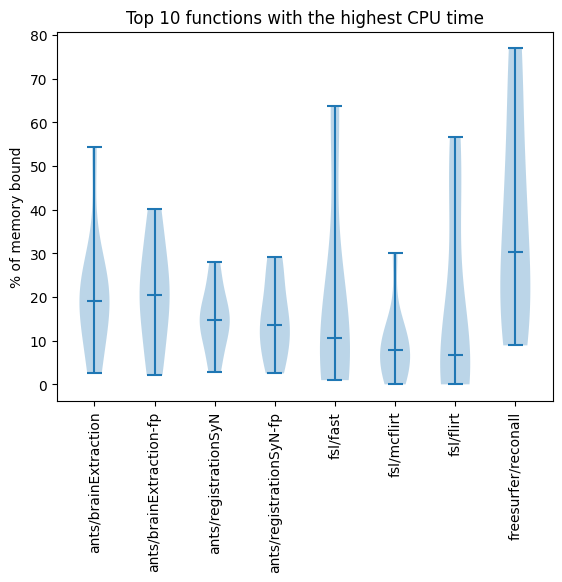

In [14]:
import matplotlib.pyplot as plt

dataset = "ds004513"
experiments: dict[str, tuple[tuple[str, float | None]]] = {
    "ants": (
        ("brainExtraction", 700),
        ("brainExtraction-fp", 700),
        ("registrationSyN", 2200),
        ("registrationSyN-fp", 2200),
    ),
    "fsl": (
        ("fast", None),
        ("mcflirt", None),
        ("flirt", None),
    ),
    "freesurfer": (("reconall", None),),
    # "fmriprep": (("full", None),),
}

k = 10
topk = dict()
mem_bound_impact = dict()
for toolkit, pipelines in experiments.items():
    for pipeline, y_limit in pipelines:
        profiling_data = read_profiling_data(
            profiling_dir / "1-threads" / toolkit / pipeline / dataset
        )
        data = data_preparation(profiling_data, keep_ratio=1)
        topk[f"{toolkit}/{pipeline}"] = data.sort_values(
            "mean_cpu", ascending=False
        ).head(k)["mean_mem_bound"]
        mem_bound_impact[f"{toolkit}/{pipeline}"] = {
            "memory": (data["mean_mem_bound"] / 100 * data["perc_cpu_time"]).sum(),
            "l1": (data["mean_l1_bound"] / 100 * data["perc_cpu_time"]).sum(),
            "l2": (data["mean_l2_bound"] / 100 * data["perc_cpu_time"]).sum(),
            "l3": (data["mean_l3_bound"] / 100 * data["perc_cpu_time"]).sum(),
            "dram": (data["mean_dram_bound"] / 100 * data["perc_cpu_time"]).sum(),
            "store": (data["mean_store_bound"] / 100 * data["perc_cpu_time"]).sum(),
        }

plt.violinplot(topk.values(), showmeans=False, showmedians=True)
plt.xticks(range(1, len(topk) + 1), topk.keys(), rotation=90)
plt.ylabel("% of memory bound")
plt.title(f"Top {k} functions with the highest CPU time")
plt.savefig(figures_dir / "topk-violinplot.png")
plt.show()

In [82]:
with open(tables_dir / "memory_bound.csv", "w") as f:
    f.write(
        "pipeline, Memory Bound (%), L1 Bound(%), L2 Bound (%), L3 Bound (%), DRAM Bound (%), Store Bound (%)\n"
    )
    for pipeline, v in mem_bound_impact.items():
        f.write(
            f"{pipeline},{v['memory']:.2f},{v['l1']:.2f},{v['l2']:.2f},{v['l3']:.2f},{v['dram']:.2f},{v['store']:.2f}\n"
        )

# Simplified hotspot plot

In [120]:
import math

from bokeh.models import (
    ColumnDataSource,
    FactorRange,
    Whisker,
)
from bokeh.plotting import figure


def plot_simple_hotspots(
    data: pd.DataFrame,
    *,
    y_limit: float | None = None,
    nthreads: int | None = None,
    pipeline: str,
):
    xs = [(module, str(i)) for i, module in enumerate(data["module_short"], start=1)]
    source = ColumnDataSource(
        data=dict(
            x=xs,
            module_short=data["module_short"].values,
            func_id=data.index.values,
            mean_cpu=data["mean_cpu"].values,
            std_cpu=data["std_cpu"].values,
            std_lower_cpu=data["mean_cpu"].values - data["std_cpu"].values,
            std_upper_cpu=data["mean_cpu"].values + data["std_cpu"].values,
        )
    )

    p = figure(
        x_range=FactorRange(*xs),
        title=(
            f"Avg. CPU Time (seconds): {pipeline}"
            + (f" with {str(nthreads)} threads" if nthreads else "")
        ),
        width=1500,
    )

    # Mean
    p.vbar(
        x="x",
        top="mean_cpu",
        width=0.9,
        source=source,
    )
    # Error
    error = Whisker(
        base="x",
        upper="std_upper_cpu",
        lower="std_lower_cpu",
        source=source,
        level="annotation",
        line_width=2,
    )
    error.upper_head.size = 20
    error.lower_head.size = 20
    p.add_layout(error)

    # Style
    if not y_limit:
        y_limit = 1.05 * (data["mean_cpu"].values + data["std_cpu"].values).max()
    p.y_range.end = y_limit
    p.y_range.start = 0
    # p.y_range = Range1d(start=0, end=y_limit)
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = math.pi / 2
    p.xaxis.group_label_orientation = math.pi / 8
    p.xaxis.separator_line_alpha = 0
    p.xgrid.grid_line_color = None
    p.yaxis.formatter.use_scientific = False

    ## Font size
    p.title.text_font_size = "25pt"
    p.xaxis.group_text_font_size = "12pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.yaxis.major_label_text_font_size = "15pt"

    # Prevent overlap of x-axis labels
    if (l := len(data)) > 120:
        p.xaxis.major_label_text_font_size = "6pt"
    elif l > 80:
        p.xaxis.major_label_text_font_size = "8pt"
    else:
        p.xaxis.major_label_text_font_size = "12pt"

    return p

## FreeSurfer

In [122]:
toolkit = "freesurfer"
pipeline = "reconall"

with remote_driver() as driver:
    for nthread in [1, 32]:
        profiling_data = read_profiling_data(
                profiling_dir / f"{nthread}-threads" / toolkit / pipeline
            )
        data = data_preparation(profiling_data, keep_ratio=0.8)

        p = plot_simple_hotspots(
            data,
            pipeline=f"{toolkit}.{pipeline}",
            y_limit=None,
            nthreads=nthread,
        )
        _filename = f"hotspots-{nthread}threads-{toolkit}-{pipeline}-simple"
        show_and_export(
            p,
            fout=figures_dir / f"{_filename}",
            driver=driver,
         )

/tmp/ipykernel_3420379/703094914.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


# Test